In [ ]:
%pip install --force-reinstall -v "tensorflow==2.19"
%pip install pandas keras keras_tuner

In [ ]:
%pip install matplotlib seaborn scikit-learn
%pip install mlflow

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import mlflow
import mlflow.keras

mlflow.set_experiment("classification_experiments")
import matplotlib.pyplot as plt



2025/10/05 17:47:37 INFO mlflow.tracking.fluent: Experiment with name 'classification_experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/federicosvendsen/Documents/UPM/NN%20%26%20DL/Assignment/mlruns/358204335309985958', creation_time=1759679257394, experiment_id='358204335309985958', last_update_time=1759679257394, lifecycle_stage='active', name='classification_experiments', tags={}>

In [7]:
input_file_path = "FootballPlayerPreparedCleanAttributes.csv"
output_file_path = "FootballPlayerOneHotEncodedClasses.csv"
input_dataframe = pd.read_csv(input_file_path)
output_dataframe = pd.read_csv(output_file_path)

In [16]:
seed_1 = 42
seed_2 = 24

train_x = input_dataframe.sample(frac = 0.8, random_state=seed_1)
test_temp_x = input_dataframe.drop(train_x.index)
test_x = test_temp_x.sample(frac = 0.5, random_state=seed_2)
validate_x = test_temp_x.drop(test_x.index)

train_y = output_dataframe.loc[train_x.index]
test_y = output_dataframe.loc[test_x.index]
validate_y = output_dataframe.loc[validate_x.index]


Epoch 1/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6197 - loss: 0.8297 - val_accuracy: 0.7918 - val_loss: 0.5063
Epoch 2/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7550 - loss: 0.5709 - val_accuracy: 0.8395 - val_loss: 0.3930
Epoch 3/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7865 - loss: 0.5179 - val_accuracy: 0.8457 - val_loss: 0.3980
Epoch 4/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7941 - loss: 0.4901 - val_accuracy: 0.8501 - val_loss: 0.3693
Epoch 5/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8023 - loss: 0.4686 - val_accuracy: 0.8383 - val_loss: 0.3739
Epoch 6/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8068 - loss: 0.4613 - val_accuracy: 0.8420 - val_loss: 0.3714
Epoch 7/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8099 - loss: 0.4523 - val_accuracy: 0.8445 - val_loss: 0.3730
Epoch 8/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8082 - loss: 0.4467 - val_accuracy: 0.

2025/10/05 22:24:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 22:24:15 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/05 22:24:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/t2/d3hrzr8x7zd9cnztszgjcw0h0000gn/T/tmpfhd8iw2e/model, flavor: keras). Fall back to return ['keras==3.11.3']. Set logging level to DEBUG to see the full traceback. 
2025/10/05 22:24:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


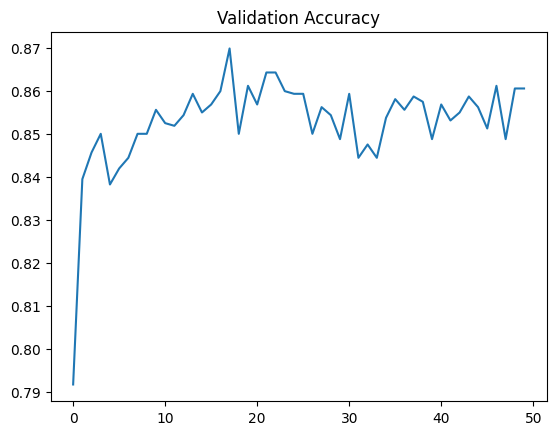

In [42]:
with mlflow.start_run(run_name=f"hyperparameter_tuning_run"):
    
    # Log hyperparameters
    mlflow.log_param("activation", "relu/tanh")
    mlflow.log_param("dropout_rate", 0.45)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 50)
    
    # Define the model
    model = keras.Sequential([
        layers.Input(shape=(22,)),                # 22 input features
        layers.Dense(256, activation='relu'),     # hidden layer 1
        layers.Dropout(0.4),                      # regularization
        layers.Dense(256, activation='tanh'),     # hidden layer 2
        layers.Dropout(0.4),
        layers.Dense(32, activation='relu'),      # hidden layer 1
        layers.Dropout(0.4),                      # regularization
        layers.Dense(32, activation='tanh'),      # hidden layer 2
        layers.Dropout(0.4),
        layers.Dense(4, activation='softmax')     # output layer (4 classes)
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_x, train_y,
        validation_data=(test_x, test_y),
        epochs=50,
        batch_size=32,
        verbose=1
    )
    
    # Log metrics (final epoch metrics)
    mlflow.log_metric("train_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("val_accuracy", history.history['val_accuracy'][-1])
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])

    plt.plot(history.history['val_accuracy'])
    plt.title('Validation Accuracy')
    plt.savefig("val_accuracy.png")
    mlflow.log_artifact("val_accuracy.png")
    
    # Log the trained Keras model
    mlflow.keras.log_model(model, "keras_model")


In [34]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers


In [32]:
def build_model(hp):
    model = keras.Sequential()
    
    # Input layer (fixed 22 features)
    model.add(layers.Input(shape=(22,)))
    
    # Tune number of hidden layers: between 1 and 3
    for i in range(hp.Int('num_layers', 1, 3)):
        for activation in ['relu', 'tanh']:
            model.add(layers.Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                activation = activation
            ))
            # Tune dropout rate per layer
            model.add(layers.Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
            ))

    # Output layer
    model.add(layers.Dense(4, activation='softmax'))

    # Tune learning rate for the Adam optimizer
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [35]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='tuner_results',
    project_name='dnn_tuning'
)


Reloading Tuner from tuner_results/dnn_tuning/tuner0.json


In [36]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    train_x, train_y,
    epochs=50,
    validation_data=(test_x, test_y),
    callbacks=[stop_early],
    verbose=1
)


In [ ]:

# Example: replace this with your run_id
run_id = "eaf4f83929a2466da5f626682e1fabd3"

# Load the model back
loaded_model = mlflow.keras.load_ººmodel(f"runs:/{run_id}/keras_model")

# Use it like any Keras model
predictions = loaded_model.predict(test_x)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
